In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import os
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
data = pd.read_csv('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/kidneyData.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)

Cyst_dir = [ r'/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst']
Normal_dirs = [r'/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal']
Stone_dirs = [r'/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone']
Tumor_dirs = [r'/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor']
filepaths = []
labels = []
dict_lists = [Cyst_dir, Normal_dirs,Stone_dirs, Tumor_dirs]
class_labels = ['Cyst', 'Normal', 'Stone', 'Tumor']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
KIDNEY_data = pd.concat([Fseries, Lseries], axis=1)
data = pd.DataFrame(KIDNEY_data)

oversample = pd.concat([data[data.labels == 'Tumor'], data[data.labels == 'Stone']], axis=0)
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
)
os.mkdir('/kaggle/working/augmentation/')
os.mkdir('/kaggle/working/augmentation/Tumor/')
os.mkdir('/kaggle/working/augmentation/Stone/')

num_classes = 4
class_counts = {'Tumor': 2283, 'Stone': 1377}
target_class_size = 2500
c = 0

np.random.seed(42)
for class_id, count in class_counts.items():
    num_samples_to_generate = target_class_size - count
    paths = np.random.choice(oversample.filepaths[oversample.labels==class_id], num_samples_to_generate)
    for path in paths:
        c+=1
        # Generate augmented data
        image = cv.imread(path)
        augmented_data = data_generator.random_transform(image)
        name = 'augmented_image_'+ str(c)+ '.jpg'

        newpath = '/kaggle/working/augmentation/' + class_id + '/' + name
        li = list()
        li.append(newpath)
        li.append(class_id)
        oversample.loc[-1] = li
        oversample.index = oversample.index + 1
        cv.imwrite(newpath, augmented_data)


Norm_df = data.iloc[np.random.choice(data[data.labels=='Normal'].index ,2500, replace=False)]
Cyst_df = data.iloc[np.random.choice(data[data.labels=='Cyst'].index ,2500, replace=False)]
downsample = pd.concat([Norm_df, Cyst_df], axis=0)
df = pd.concat([oversample, downsample], axis=0)
import shutil, os
train_path = r'/kaggle/working/train'
test_path  = r'/kaggle/working/test'
val_path   = r'/kaggle/working/val'
paths = [train_path, test_path, val_path]
subfolders = df.labels.unique().tolist()
for x in paths:
    os.mkdir(x)
    for i in subfolders:
        os.mkdir(x+'/'+i)
df = shuffle(df)
counter=0
for sub in subfolders:
    c=0
    for destination, i in zip(paths, [0.7, 0.15, 0.15]):
        print(destination+'/'+sub)
        for source in df['filepaths'][df.labels==sub][c:c+int(2500*i)]:
            try:
                shutil.copy(source, destination+'/'+sub)
            except FileNotFoundError:
                counter+=1
                pass
        c+=int(2500*i)
print(f'there are {counter} did not found in directory')

In [10]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
#     zoom_range=0.2,
#     horizontal_flip=True
)

train = generator.flow_from_directory(
    '/kaggle/working/train',
    target_size=(224,224),
    class_mode="categorical",
    batch_size=64,
)
validation = generator.flow_from_directory(
    '/kaggle/working/val',
    target_size=(224,224),
    class_mode="categorical",
    batch_size=64,
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

test = test_generator.flow_from_directory(
    '/kaggle/working/test',
    target_size=(224,224),
    class_mode="categorical",
    batch_size=64,
)

Found 7000 images belonging to 4 classes.
Found 1500 images belonging to 4 classes.
Found 1500 images belonging to 4 classes.


Found 7000 images belonging to 4 classes.
Found 1500 images belonging to 4 classes.
Found 1500 images belonging to 4 classes.


In [ ]:
classes=list(train.class_indices.keys())
print(classes)

Found 1500 images belonging to 4 classes.


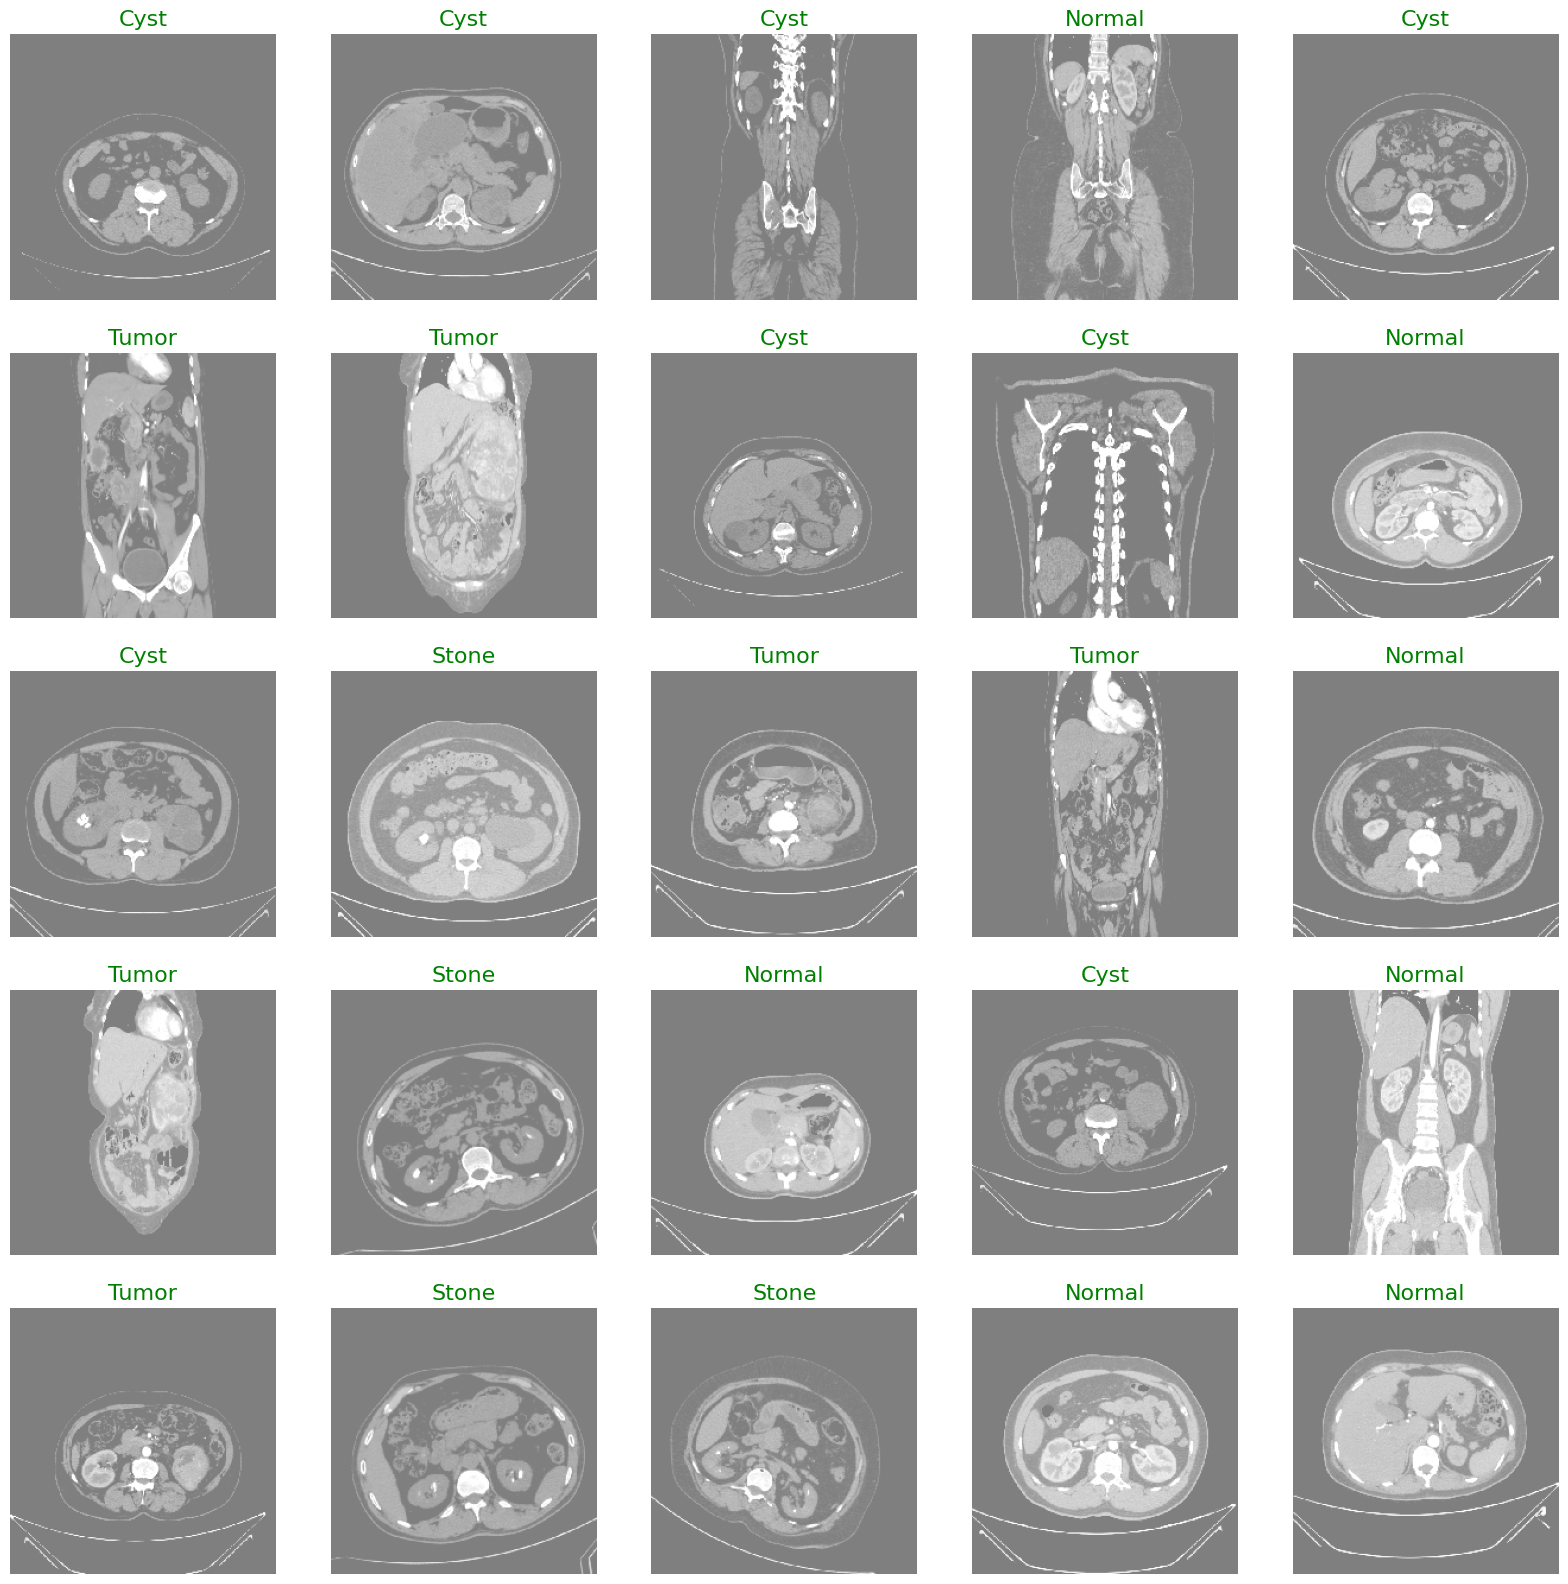

In [140]:
def show_KIDNEY_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        image=cv.cvtColor(image, cv.COLOR_BGR2RGB)
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

augmented = test_generator.flow_from_directory(
    '/kaggle/working/val',
    target_size=(224,224),
    class_mode="categorical",
    batch_size=32,
)
show_KIDNEY_images(augmented)

In [ ]:
path='/kaggle/working/augmentation/'
filepaths = []
flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)

In [ ]:
data_augmentaion = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
])

# CNN

In [ ]:
cnn_2 = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [ ]:
cnn_2.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
histroy = cnn_2.fit(train, validation_data=validation, epochs=10)

In [ ]:
cnn_2.evaluate(test, verbose=1)

In [ ]:
model.save("KIDNEY-Diseases.h5")

In [ ]:
import seaborn as sns
sns.set_theme()
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.plot(histroy.history['loss'], '-o', label='training')
plt.plot(histroy.history['val_loss'], '-o', label='validation')

In [ ]:
plt.title('model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.plot(histroy.history['acc'], '-o', label='training')
plt.plot(histroy.history['val_acc'], '-o', label='validation')

In [ ]:
pred = cnn_2.predict(test)

In [ ]:
!pip install tqdm

In [ ]:
import tqdm
test.reset()
X_test, y_test = next(test)
for i in tqdm.tqdm(range(int(test.n/8)-1)): 
  img, label = next(test)
  X_test = np.append(X_test, img, axis=0 )
  y_test = np.append(y_test, label, axis=0)
print(X_test.shape, y_test.shape)

In [ ]:
pred = cnn_2.predict(test)
pred = np.argmax(pred, axis=1)

In [ ]:
from sklearn.metrics import precision_score, recall_score

In [ ]:
y_test = np.argmax(y_test, axis=1)
print(classification_report(y_test, pred[:-4]))
print("Accuracy of the Model: ","{:.4f}%".format(accuracy_score(y_test, pred[:-4])*100))
print("Accuracy of the Model: ","{:.4f}%".format(precision_score(y_test, pred[:-4], average='weighted')*100))
print("Accuracy of the Model: ","{:.4f}%".format(recall_score(y_test, pred[:-4], average='weighted')*100))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Cyst', 'Normal', 'Stone', 'Tumor']


cm = confusion_matrix(y_test, pred[:-4])

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

# Another Arche

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

In [ ]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
histroy = model.fit(train, validation_data=validation, epochs=10)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
model.save("KIDNEY-Diseases.h5")

In [ ]:
import seaborn as sns
sns.set_theme()
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.plot(histroy.history['loss'], '-o', label='training')
plt.plot(histroy.history['val_loss'], '-o', label='validation')

In [ ]:
plt.title('model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.plot(histroy.history['acc'], '-o', label='training')
plt.plot(histroy.history['val_acc'], '-o', label='validation')

In [ ]:
!pip install tqdm

In [ ]:
import tqdm
test.reset()
X_test, y_test = next(test)
for i in tqdm.tqdm(range(int(test.n/8)-1)): 
  img, label = next(test)
  X_test = np.append(X_test, img, axis=0 )
  y_test = np.append(y_test, label, axis=0)
print(X_test.shape, y_test.shape)

In [ ]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1)

In [ ]:
y_test = np.argmax(y_test, axis=1)
print(classification_report(y_test, pred[:-4]))
print("Accuracy of the Model: ","{:.4f}%".format(accuracy_score(y_test, pred[:-4])*100))
print("Accuracy of the Model: ","{:.4f}%".format(precision_score(y_test, pred[:-4], average='weighted')*100))
print("Accuracy of the Model: ","{:.4f}%".format(recall_score(y_test, pred[:-4], average='weighted')*100))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Cyst', 'Normal', 'Stone', 'Tumor']


cm = confusion_matrix(y_test, pred[:-4])

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

# 

# 

# 

# 

In [15]:
import tqdm
test.reset()
_, y_test = next(test)
for i in tqdm.tqdm(range(int(test.n/8)-1)): 
  _, label = next(test)
  y_test = np.append(y_test, label, axis=0)
print(y_test.shape)
y_test = np.argmax(y_test, axis=1)

100%|██████████| 186/186 [00:04<00:00, 37.71it/s]

(1496, 4)


In [16]:
import tqdm
train.reset()
_, y_train = next(train)
for i in tqdm.tqdm(range(int(train.n/8)-1)): 
  _, label = next(train)
  y_train = np.append(y_train, label, axis=0)
y_train = np.argmax(y_train, axis=1)

100%|██████████| 874/874 [00:22<00:00, 39.37it/s]


# Transfer Learning 

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

# VGG

In [138]:
base_model = VGG19(weights='imagenet', include_top=False)

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = Dense(4, activation='softmax')(x)

# Create the full model
vgg = Model(inputs=base_model.input, outputs=output)

for layer in vgg.layers[:-3]:
    layer.trainable = False
vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = vgg.fit(train, validation_data=validation, epochs=10)

Epoch 1/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 65s 74ms/step - acc: 0.9639 - loss: 0.1057 - val_acc: 0.9660 - val_loss: 0.1050
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 65s 74ms/step - acc: 0.9573 - loss: 0.1104 - val_acc: 0.9747 - val_loss: 0.0772
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 65s 74ms/step - acc: 0.9702 - loss: 0.0860 - val_acc: 0.9780 - val_loss: 0.0726
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 65s 74ms/step - acc: 0.9610 - loss: 0.1130 - val_acc: 0.9820 - val_loss: 0.0582
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 65s 74ms/step - acc: 0.9705 - loss: 0.0838 - val_acc: 0.9800 - val_loss: 0.0577
Epoch 6/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 65s 74ms/step - acc: 0.9770 - loss: 0.0697 - val_acc: 0.9733 - val_loss: 0.0764
Epoch 7/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 65s 74ms/step - acc: 0.9691 - loss: 0.0839 - val_acc: 0.9773 - val_loss: 0.0696
Epoch 8/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 65s 74ms/step - acc: 0.9722 - loss: 0.0816 - val_acc: 0.9727 - val_loss: 0.0742
Epoch 9/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 

In [141]:
print(vgg.evaluate(test, verbose=1))

188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - acc: 0.9864 - loss: 0.0481
[0.06029044836759567, 0.9819999933242798]


In [142]:
vgg.save('vgg.h5')

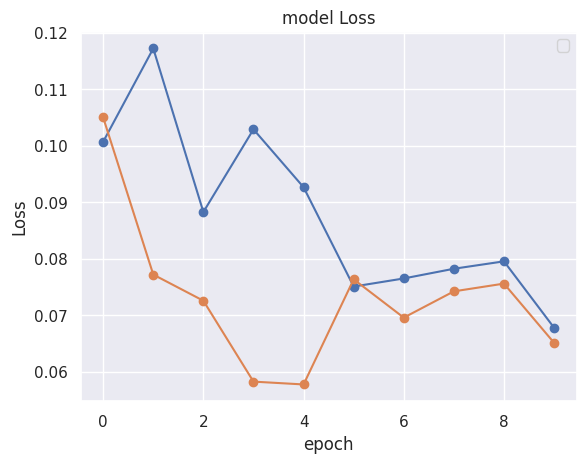

In [143]:
import seaborn as sns
sns.set_theme()
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.plot(history.history['loss'], '-o', label='training')
plt.plot(history.history['val_loss'], '-o', label='validation')

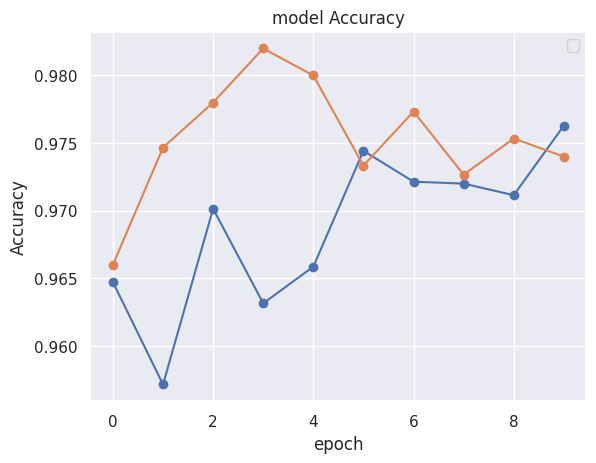

In [144]:
plt.title('model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.plot(history.history['acc'], '-o', label='training')
plt.plot(history.history['val_acc'], '-o', label='validation')

In [145]:
import tqdm
test.reset()
_, y_test = next(test)
for i in tqdm.tqdm(range(int(test.n/8)-1)): 
  _, label = next(test)
  y_test = np.append(y_test, label, axis=0)
print(y_test.shape)
y_test = np.argmax(y_test, axis=1)

100%|██████████| 186/186 [00:04<00:00, 38.15it/s]

(1496, 4)


In [146]:
import tqdm
train.reset()
_, y_train = next(train)
for i in tqdm.tqdm(range(int(train.n/8)-1)): 
  _, label = next(train)
  y_train = np.append(y_train, label, axis=0)
y_train = np.argmax(y_train, axis=1)

100%|██████████| 874/874 [00:23<00:00, 37.72it/s]


In [147]:
predd = vgg.predict(test)
pred = predd
pred = np.argmax(pred, axis=1)

188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step


In [148]:

print(classification_report(y_test, pred[:-4]))
print("Accuracy of the Model: ","{:.4f}%".format(accuracy_score(y_test, pred[:-4])*100))
print("Accuracy of the Model: ","{:.4f}%".format(precision_score(y_test, pred[:-4], average='weighted')*100))
print("Accuracy of the Model: ","{:.4f}%".format(recall_score(y_test, pred[:-4], average='weighted')*100))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       373
           1       1.00      0.99      0.99       375
           2       0.94      1.00      0.97       374
           3       0.99      0.99      0.99       374

    accuracy                           0.98      1496
   macro avg       0.98      0.98      0.98      1496
weighted avg       0.98      0.98      0.98      1496

Accuracy of the Model:  98.1952%
Accuracy of the Model:  98.2916%
Accuracy of the Model:  98.1952%


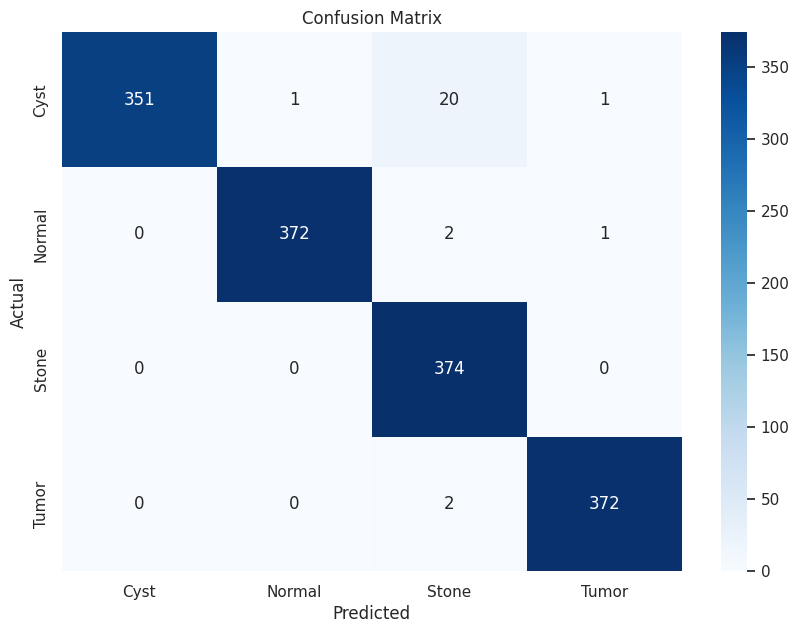

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Cyst', 'Normal', 'Stone', 'Tumor']


cm = confusion_matrix(y_test, pred[:-4])

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

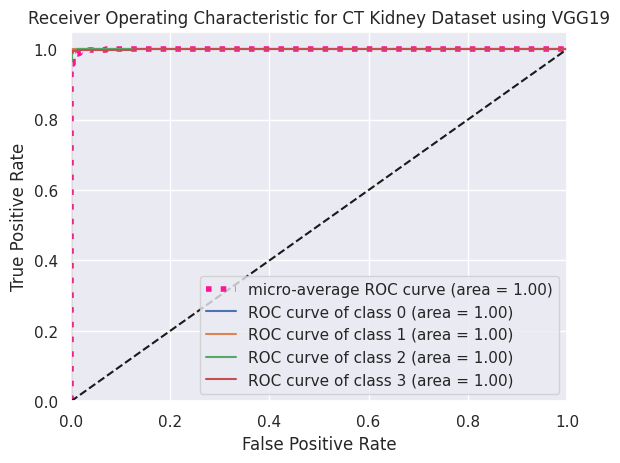

In [150]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import seaborn as sns
sns.set_theme()
pred=predd[:-4]
y_train_bin = label_binarize(y_train, classes=np.unique(y_train))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
num_classes = 4
# y_score = vgg.predict(X_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for CT Kidney Dataset using VGG19')
plt.legend(loc="lower right")
plt.show()

# 

# 

# ResNet

In [104]:
base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = Dense(4, activation='softmax')(x)


# Create the full model
res = Model(inputs=base_model.input, outputs=output)
for layer in res.layers[:-3]:
    layer.trainable = False
res.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = res.fit(train, validation_data=validation, epochs=15)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
  5/875 ━━━━━━━━━━━━━━━━━━━━ 37s 43ms/step - acc: 0.4137 - loss: 1.5887  

W0000 00:00:1711197843.333861     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.4171 - loss: 1.3392

W0000 00:00:1711197874.427061     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


875/875 ━━━━━━━━━━━━━━━━━━━━ 55s 47ms/step - acc: 0.4172 - loss: 1.3390 - val_acc: 0.5607 - val_loss: 0.9535
Epoch 2/15


W0000 00:00:1711197884.009311     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


875/875 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - acc: 0.6304 - loss: 0.8981 - val_acc: 0.7293 - val_loss: 0.6900
Epoch 3/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - acc: 0.7049 - loss: 0.7396 - val_acc: 0.7407 - val_loss: 0.6799
Epoch 4/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - acc: 0.7393 - loss: 0.6595 - val_acc: 0.8013 - val_loss: 0.5547
Epoch 5/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - acc: 0.7736 - loss: 0.5761 - val_acc: 0.7180 - val_loss: 0.6638
Epoch 6/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - acc: 0.7968 - loss: 0.5306 - val_acc: 0.7693 - val_loss: 0.6016
Epoch 7/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - acc: 0.7977 - loss: 0.5090 - val_acc: 0.7547 - val_loss: 0.5888
Epoch 8/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - acc: 0.8040 - loss: 0.4897 - val_acc: 0.8647 - val_loss: 0.3775
Epoch 9/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - acc: 0.8154 - loss: 0.4744 - val_acc: 0.8587 - val_loss: 0.3801
Epoch 10/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/s

In [125]:
history = res.fit(train, validation_data=validation, epochs=5)

Epoch 1/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - acc: 0.8966 - loss: 0.2669 - val_acc: 0.9307 - val_loss: 0.1853
Epoch 2/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - acc: 0.9188 - loss: 0.2177 - val_acc: 0.8440 - val_loss: 0.4091
Epoch 3/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - acc: 0.9124 - loss: 0.2298 - val_acc: 0.9493 - val_loss: 0.1645
Epoch 4/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - acc: 0.9147 - loss: 0.2305 - val_acc: 0.9347 - val_loss: 0.1905
Epoch 5/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - acc: 0.9120 - loss: 0.2271 - val_acc: 0.9467 - val_loss: 0.1592


In [126]:
print(res.evaluate(test, verbose=1))

188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - acc: 0.9518 - loss: 0.1440
[0.12935160100460052, 0.9573333263397217]


In [139]:
res.save('resnet.h5')

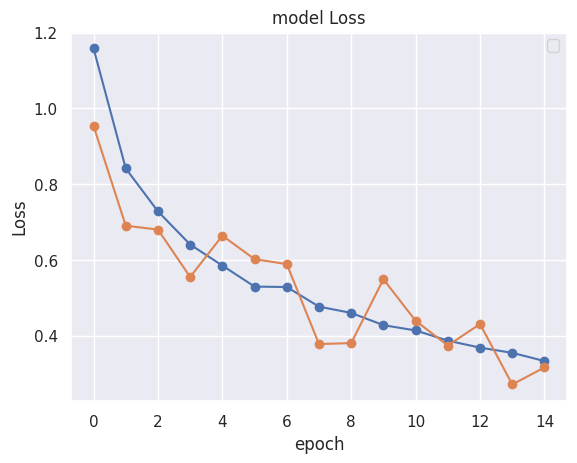

In [106]:
import seaborn as sns
sns.set_theme()
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.plot(history.history['loss'], '-o', label='training')
plt.plot(history.history['val_loss'], '-o', label='validation')

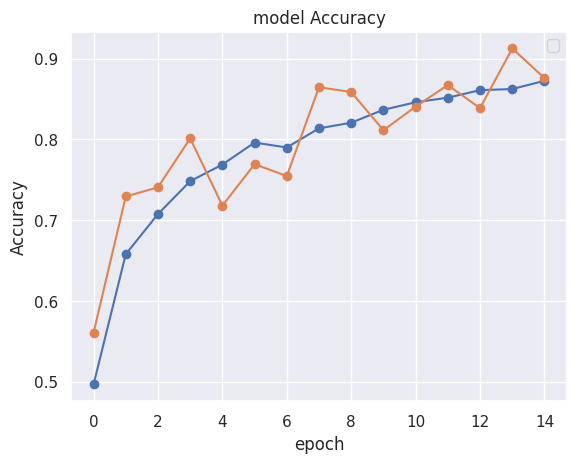

In [107]:
plt.title('model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.plot(history.history['acc'], '-o', label='training')
plt.plot(history.history['val_acc'], '-o', label='validation')

In [127]:
import tqdm
test.reset()
_, y_test = next(test)
for i in tqdm.tqdm(range(int(test.n/8)-1)): 
  _, label = next(test)
  y_test = np.append(y_test, label, axis=0)
print(y_test.shape)
y_test = np.argmax(y_test, axis=1)

100%|██████████| 186/186 [00:04<00:00, 38.61it/s]

(1496, 4)


In [128]:
import tqdm
train.reset()
_, y_train = next(train)
for i in tqdm.tqdm(range(int(train.n/8)-1)): 
  _, label = next(train)
  y_train = np.append(y_train, label, axis=0)
y_train = np.argmax(y_train, axis=1)

100%|██████████| 874/874 [00:23<00:00, 37.91it/s]


In [129]:
predd = res.predict(test)
pred = predd
pred = np.argmax(pred, axis=1)

188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step


In [130]:
print(classification_report(y_test, pred[:-4]))
print("Accuracy of the Model: ","{:.1f}%".format(accuracy_score(y_test, pred[:-4])*100))
print("Accuracy of the Model: ","{:.4f}%".format(precision_score(y_test, pred[:-4], average='weighted')*100))
print("Accuracy of the Model: ","{:.4f}%".format(recall_score(y_test, pred[:-4], average='weighted')*100))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95       374
           1       1.00      0.94      0.97       374
           2       0.93      0.98      0.95       373
           3       0.93      0.99      0.96       375

    accuracy                           0.96      1496
   macro avg       0.96      0.96      0.96      1496
weighted avg       0.96      0.96      0.96      1496

Accuracy of the Model:  95.7%
Accuracy of the Model:  95.8787%
Accuracy of the Model:  95.7219%


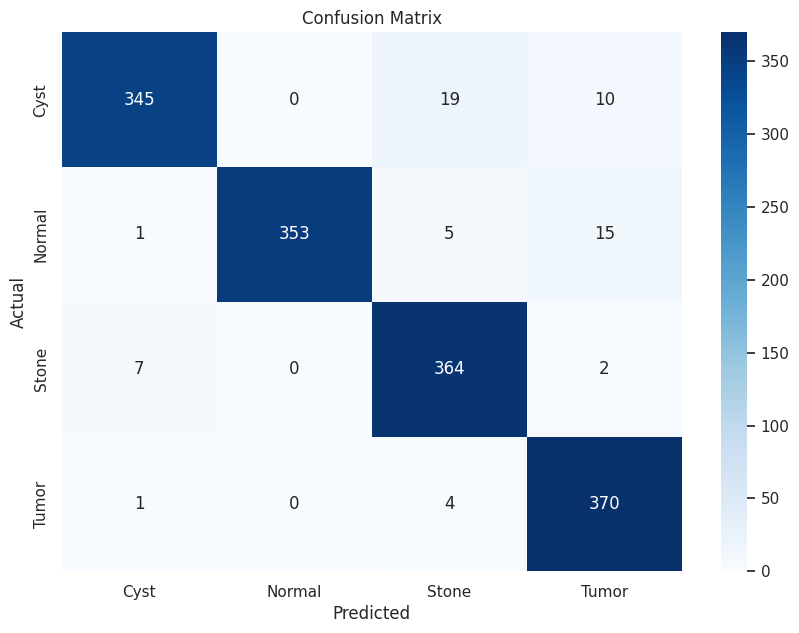

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Cyst', 'Normal', 'Stone', 'Tumor']


cm = confusion_matrix(y_test, pred[:-4])

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

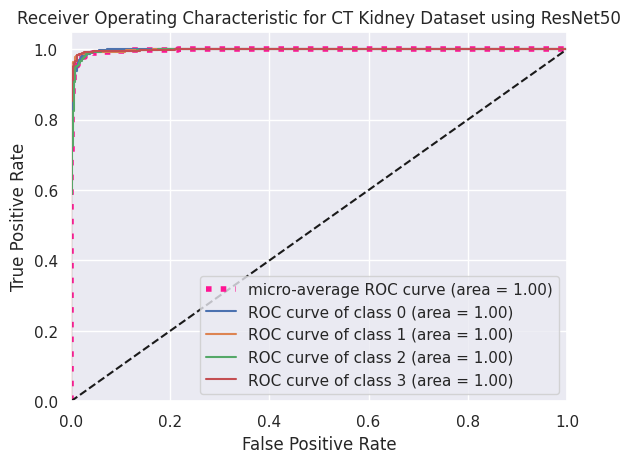

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import seaborn as sns
sns.set_theme()
pred=predd[:-4]
y_train_bin = label_binarize(y_train, classes=np.unique(y_train))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
num_classes = 4
# y_score = vgg.predict(X_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for CT Kidney Dataset using ResNet50')
plt.legend(loc="lower right")
plt.show()

# 

# 

# DenseNet

In [ ]:
base_model = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet')
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
output = Dense(4, activation='softmax')(x)

# Create the full model
des = Model(inputs=base_model.input, outputs=output)

for layer in des.layers[:-2]:
    layer.trainable = False
des.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = des.fit(train, validation_data=validation, epochs=15)

In [ ]:
print(des.evaluate(test, verbose=1))

In [ ]:
import seaborn as sns
sns.set_theme()
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.plot(histroy.history['loss'], '-o', label='training')
plt.plot(histroy.history['val_loss'], '-o', label='validation')

In [ ]:
plt.title('model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.plot(histroy.history['acc'], '-o', label='training')
plt.plot(histroy.history['val_acc'], '-o', label='validation')

In [ ]:
pred = des.predict(test)
pred = np.argmax(pred, axis=1)
print(classification_report(y_test, pred[:-4]))
print("Accuracy of the Model: ","{:.1f}%".format(accuracy_score(y_test, pred[:-4])*100))
print("Accuracy of the Model: ","{:.4f}%".format(precision_score(y_test, pred[:-4], average='weighted')*100))
print("Accuracy of the Model: ","{:.4f}%".format(recall_score(y_test, pred[:-4], average='weighted')*100))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Cyst', 'Normal', 'Stone', 'Tumor']


cm = confusion_matrix(y_test, pred[:-4])

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import seaborn as sns
sns.set_theme()
pred=pred[:-4]
y_train_bin = label_binarize(y_train, classes=np.unique(y_train))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
num_classes = 4
# y_score = vgg.predict(X_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for CT Kidney Dataset using VGG19')
plt.legend(loc="lower right")
plt.show()

# 

# 

# EfficientNet

In [ ]:
base_model = tf.keras.applications.EfficientNetB2(include_top=False, weights='imagenet')
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
output = Dense(4, activation='softmax')(x)

# Create the full model
eff = Model(inputs=base_model.input, outputs=output)

for layer in eff.layers[:-2]:
    layer.trainable = False
eff.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = eff.fit(train, validation_data=validation, epochs=25)

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25
  1/110 ━━━━━━━━━━━━━━━━━━━━ 1:45:24 58s/step - acc: 0.2812 - loss: 1.3881

W0000 00:00:1711212348.074846     360 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 24/110 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.2733 - loss: 1.5551

W0000 00:00:1711212390.713054     359 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - acc: 0.2659 - loss: 1.4656

W0000 00:00:1711212423.348098     358 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


110/110 ━━━━━━━━━━━━━━━━━━━━ 149s 832ms/step - acc: 0.2659 - loss: 1.4651 - val_acc: 0.2500 - val_loss: 1.3990
Epoch 2/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 39s 335ms/step - acc: 0.2372 - loss: 1.3955 - val_acc: 0.2500 - val_loss: 1.3864
Epoch 3/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 350ms/step - acc: 0.2490 - loss: 1.3875 - val_acc: 0.2500 - val_loss: 1.3863
Epoch 4/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - acc: 0.2472 - loss: 1.3868

In [ ]:
print(eff.evaluate(test, verbose=1))

In [ ]:
import seaborn as sns
sns.set_theme()
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.plot(history.history['loss'], '-o', label='training')
plt.plot(history.history['val_loss'], '-o', label='validation')

In [ ]:
plt.title('model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.plot(history.history['acc'], '-o', label='training')
plt.plot(history.history['val_acc'], '-o', label='validation')

In [ ]:
import tqdm
test.reset()
X_test, y_test = next(test)
for i in tqdm.tqdm(range(int(test.n/64)-1)): 
    img, label = next(test)
    X_test = np.append(X_test, img, axis=0)
    y_test = np.append(y_test, label, axis=0)
print(y_test.shape)
y_test = np.argmax(y_test, axis=1)

In [ ]:
import tqdm
train.reset()
_, y_train = next(train)
for i in tqdm.tqdm(range(int(train.n/64)-1)): 
  _, label = next(train)
  y_train = np.append(y_train, label, axis=0)
y_train = np.argmax(y_train, axis=1)

In [ ]:
predd = eff.predict(X_test)
pred = predd
pred = np.argmax(pred, axis=1)

In [ ]:
print(classification_report(y_test, pred))
print("Accuracy of the Model: ","{:.4f}%".format(accuracy_score(y_test, pred)*100))
print("Accuracy of the Model: ","{:.4f}%".format(precision_score(y_test, pred, average='weighted')*100))
print("Accuracy of the Model: ","{:.4f}%".format(recall_score(y_test, pred, average='weighted')*100))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Cyst', 'Normal', 'Stone', 'Tumor']


cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import seaborn as sns
sns.set_theme()
pred=predd
y_train_bin = label_binarize(y_train, classes=np.unique(y_train))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
num_classes = 4
# y_score = vgg.predict(X_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.5f})'.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.5f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for CT Kidney Dataset using EffeicientNet')
plt.legend(loc="lower right")
plt.show()

# 

# 

# InceptionV3

In [34]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = Dense(4, activation='softmax')(x)


# Create the full model
ce = Model(inputs=base_model.input, outputs=output)
for layer in ce.layers[:-3]:
    layer.trainable = False
ce.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = ce.fit(train, validation_data=validation, epochs=15)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
  5/875 ━━━━━━━━━━━━━━━━━━━━ 33s 39ms/step - acc: 0.1975 - loss: 4.2643  

W0000 00:00:1711195713.186836     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


874/875 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - acc: 0.6438 - loss: 1.1858

W0000 00:00:1711195746.756254     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


875/875 ━━━━━━━━━━━━━━━━━━━━ 67s 54ms/step - acc: 0.6441 - loss: 1.1847 - val_acc: 0.8780 - val_loss: 0.3412
Epoch 2/15


W0000 00:00:1711195760.684570     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - acc: 0.8777 - loss: 0.3356 - val_acc: 0.9173 - val_loss: 0.2160
Epoch 3/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - acc: 0.9252 - loss: 0.1986 - val_acc: 0.9140 - val_loss: 0.2331
Epoch 4/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - acc: 0.9388 - loss: 0.1606 - val_acc: 0.9453 - val_loss: 0.1506
Epoch 5/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - acc: 0.9487 - loss: 0.1407 - val_acc: 0.8820 - val_loss: 0.3431
Epoch 6/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - acc: 0.9609 - loss: 0.1165 - val_acc: 0.9513 - val_loss: 0.1329
Epoch 7/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - acc: 0.9585 - loss: 0.1109 - val_acc: 0.9433 - val_loss: 0.1433
Epoch 8/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - acc: 0.9583 - loss: 0.1129 - val_acc: 0.9707 - val_loss: 0.0838
Epoch 9/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - acc: 0.9742 - loss: 0.0757 - val_acc: 0.9713 - val_loss: 0.0833
Epoch 10/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/s

In [ ]:
history = ce.fit(train, validation_data=validation, epochs=5)

Epoch 1/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - acc: 0.9887 - loss: 0.0350 - val_acc: 0.9767 - val_loss: 0.0792
Epoch 2/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - acc: 0.9880 - loss: 0.0349 - val_acc: 0.9793 - val_loss: 0.0549
Epoch 3/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - acc: 0.9875 - loss: 0.0382 - val_acc: 0.9833 - val_loss: 0.0615
Epoch 4/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - acc: 0.9888 - loss: 0.0331 - val_acc: 0.9767 - val_loss: 0.0701
Epoch 5/5
785/875 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - acc: 0.9797 - loss: 0.0578

In [52]:
print(ce.evaluate(test, verbose=1))

188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - acc: 0.9777 - loss: 0.0768
[0.07182856649160385, 0.9800000190734863]


In [110]:
ce.save('Inception.h5')

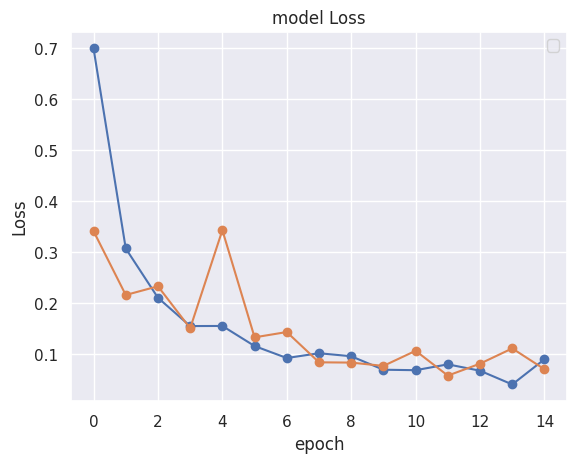

In [36]:
import seaborn as sns
sns.set_theme()
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.plot(history.history['loss'], '-o', label='training')
plt.plot(history.history['val_loss'], '-o', label='validation')

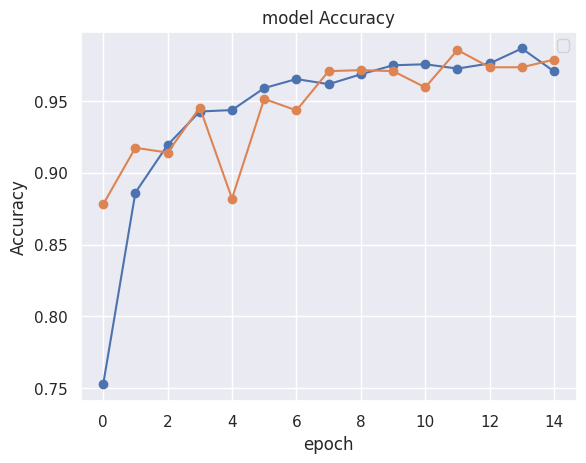

In [37]:
plt.title('model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.plot(history.history['acc'], '-o', label='training')
plt.plot(history.history['val_acc'], '-o', label='validation')

In [96]:
import tqdm
test.reset()
X_test, y_test = next(test)
for i in tqdm.tqdm(range(int(test.n/8)-1)): 
    img, label = next(test)
    X_test = np.append(X_test, img, axis=0)
    y_test = np.append(y_test, label, axis=0)
print(y_test.shape)
y_test = np.argmax(y_test, axis=1)

100%|██████████| 186/186 [00:04<00:00, 38.04it/s]

(1496, 4)


In [97]:
import tqdm
train.reset()
_, y_train = next(train)
for i in tqdm.tqdm(range(int(train.n/8)-1)): 
  _, label = next(train)
  y_train = np.append(y_train, label, axis=0)
y_train = np.argmax(y_train, axis=1)

100%|██████████| 874/874 [00:23<00:00, 37.96it/s]


In [98]:
predd = ce.predict(test)
pred = predd
pred = np.argmax(pred, axis=1)

188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step


In [99]:
pred

array([1, 3, 2, ..., 0, 0, 1])

In [100]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
print(classification_report(y_test, pred))
print("Accuracy of the Model: ","{:.4f}%".format(accuracy_score(y_test, pred)*100))
print("Accuracy of the Model: ","{:.4f}%".format(precision_score(y_test, pred, average='weighted')*100))
print("Accuracy of the Model: ","{:.4f}%".format(recall_score(y_test, pred, average='weighted')*100))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       372
           1       0.98      0.98      0.98       374
           2       0.99      0.96      0.98       375
           3       0.99      0.98      0.99       375

    accuracy                           0.98      1496
   macro avg       0.98      0.98      0.98      1496
weighted avg       0.98      0.98      0.98      1496

Accuracy of the Model:  98.0%
Accuracy of the Model:  98.0210%
Accuracy of the Model:  97.9947%


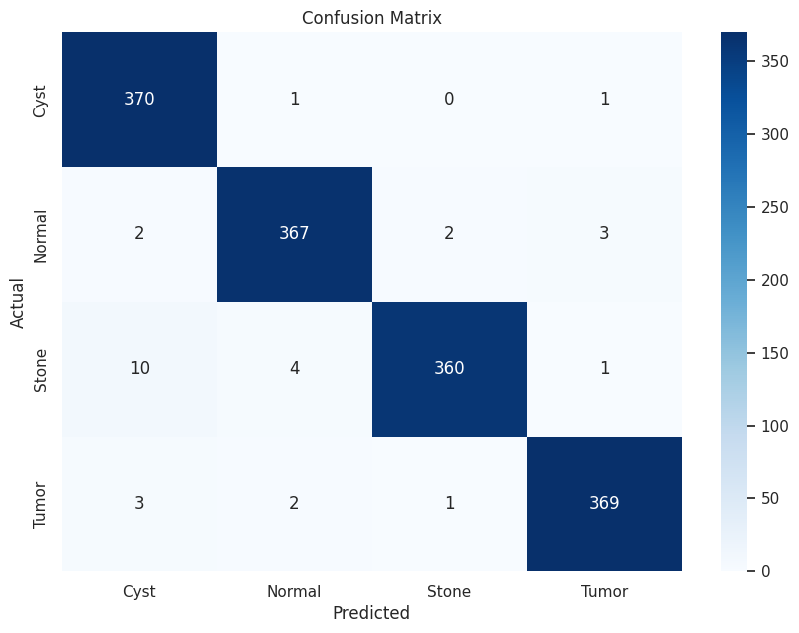

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Cyst', 'Normal', 'Stone', 'Tumor']


cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

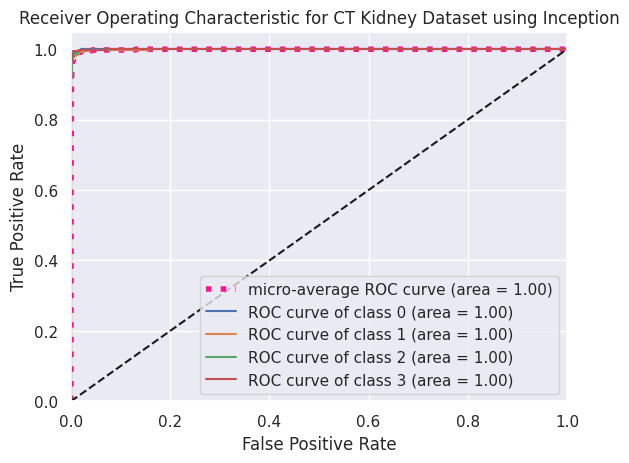

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import seaborn as sns
sns.set_theme()
pred=predd
y_train_bin = label_binarize(y_train, classes=np.unique(y_train))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
num_classes = 4
# y_score = vgg.predict(X_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for CT Kidney Dataset using Inception')
plt.legend(loc="lower right")
plt.show()

# 

# 

# MobileNetV2

In [10]:
base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet')
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)


# Create the full model
net = Model(inputs=base_model.input, outputs=output)
for layer in net.layers[:-5]:
    layer.trainable = False
net.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = net.fit(train, validation_data=validation, epochs=5)

Epoch 1/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - acc: 0.5901 - loss: 1.2147 - val_acc: 0.9033 - val_loss: 0.2627
Epoch 2/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - acc: 0.8361 - loss: 0.4258 - val_acc: 0.9300 - val_loss: 0.2031
Epoch 3/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 32s 36ms/step - acc: 0.8815 - loss: 0.3161 - val_acc: 0.9093 - val_loss: 0.2333
Epoch 4/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 32s 36ms/step - acc: 0.9161 - loss: 0.2341 - val_acc: 0.9640 - val_loss: 0.1029
Epoch 5/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 32s 37ms/step - acc: 0.9248 - loss: 0.2120 - val_acc: 0.9667 - val_loss: 0.1036
Epoch 6/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 32s 36ms/step - acc: 0.9294 - loss: 0.2021 - val_acc: 0.9873 - val_loss: 0.0525
Epoch 7/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 32s 36ms/step - acc: 0.9463 - loss: 0.1638 - val_acc: 0.9893 - val_loss: 0.0359
Epoch 8/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 32s 36ms/step - acc: 0.9438 - loss: 0.1616 - val_acc: 0.9820 - val_loss: 0.0602
Epoch 9/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 

In [151]:
history = net.fit(train, validation_data=validation, epochs=5)

Epoch 1/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - acc: 0.9756 - loss: 0.0931 - val_acc: 0.9933 - val_loss: 0.0222
Epoch 2/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - acc: 0.9631 - loss: 0.1284 - val_acc: 0.9887 - val_loss: 0.0373
Epoch 3/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - acc: 0.9679 - loss: 0.1141 - val_acc: 0.9907 - val_loss: 0.0226
Epoch 4/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - acc: 0.9732 - loss: 0.0865 - val_acc: 0.9880 - val_loss: 0.0331
Epoch 5/5
875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - acc: 0.9593 - loss: 0.1350 - val_acc: 0.9920 - val_loss: 0.0310


In [18]:
print(net.evaluate(test, verbose=1))

188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - acc: 0.9916 - loss: 0.0443
[0.040908731520175934, 0.9913333058357239]


In [109]:
net.save('mobilenet.h5')

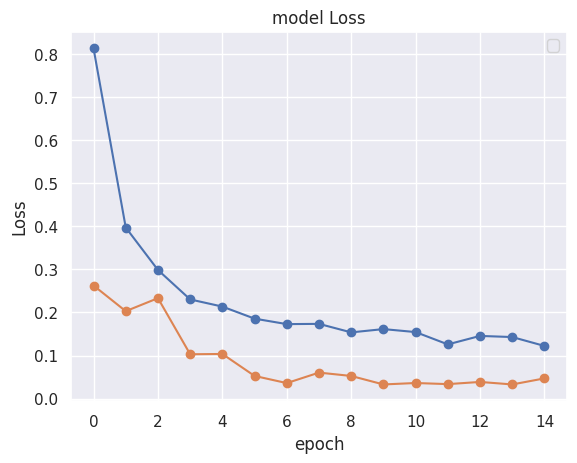

In [12]:
import seaborn as sns
sns.set_theme()
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.plot(history.history['loss'], '-o', label='training')
plt.plot(history.history['val_loss'], '-o', label='validation')

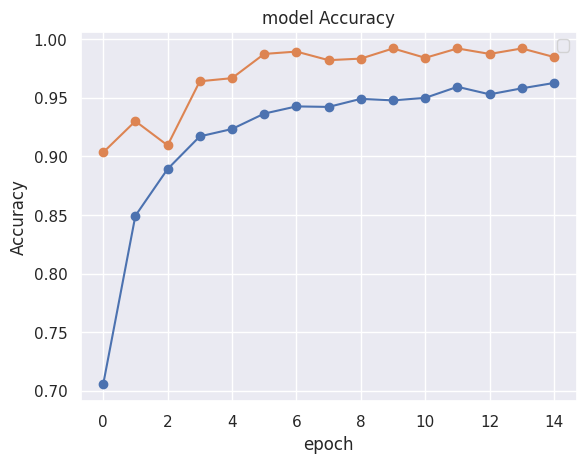

In [13]:
plt.title('model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.plot(history.history['acc'], '-o', label='training')
plt.plot(history.history['val_acc'], '-o', label='validation')

In [33]:
pred = net.predict(test)
pred = np.argmax(pred, axis=1)
print(classification_report(y_test, pred[:-4]))
print("Accuracy of the Model: ","{:.4f}%".format(accuracy_score(y_test, pred[:-4])*100))
print("Accuracy of the Model: ","{:.4f}%".format(precision_score(y_test, pred[:-4], average='weighted')*100))
print("Accuracy of the Model: ","{:.4f}%".format(recall_score(y_test, pred[:-4], average='weighted')*100))

188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       375
           1       1.00      0.99      1.00       374
           2       0.99      0.99      0.99       375
           3       0.99      0.99      0.99       372

    accuracy                           0.99      1496
   macro avg       0.99      0.99      0.99      1496
weighted avg       0.99      0.99      0.99      1496

Accuracy of the Model:  99.1310%
Accuracy of the Model:  99.1317%
Accuracy of the Model:  99.1310%


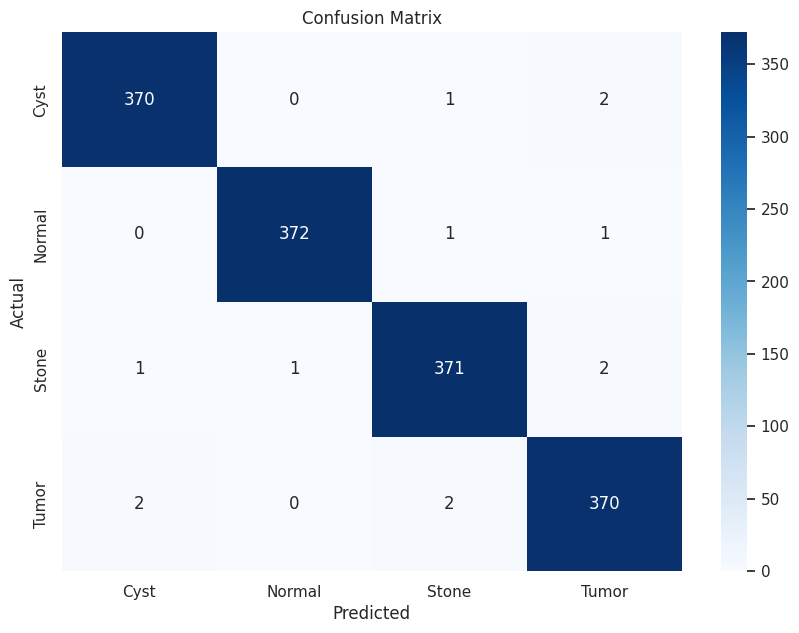

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Cyst', 'Normal', 'Stone', 'Tumor']


cm = confusion_matrix(y_test, pred[:-4])

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step


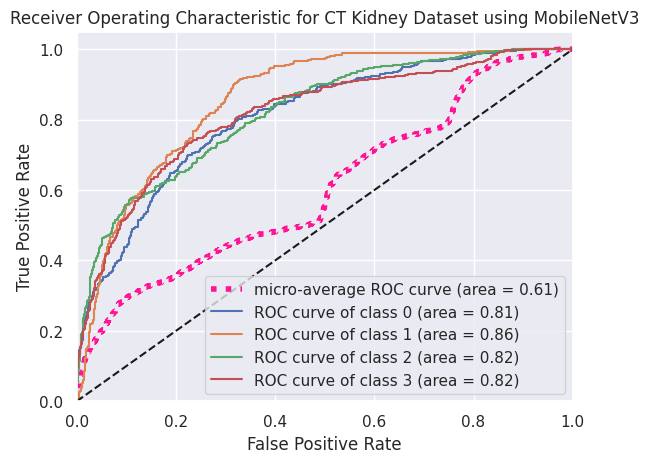

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import seaborn as sns
sns.set_theme()
pred = net.predict(test)
pred=pred[:-4]
y_train_bin = label_binarize(y_train, classes=np.unique(y_train))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
num_classes = 4
# y_score = vgg.predict(X_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for CT Kidney Dataset using MobileNetV3')
plt.legend(loc="lower right")
plt.show()